#Preprocessing of the initial data
The data for the NNs to analize are text sequences that consist of nucleotide symbols "A", "T", "G", "C".

Initial data is obtained from the database of the National Center for Biotechnology Information (NCBI) in a special format for genetic sequences — FASTA. Here is an example of a record of a single sequence sample:

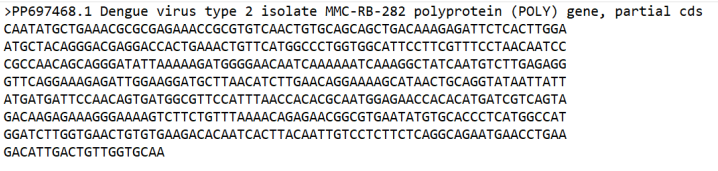

 The line after the ">" symbol contains unique number and description of given genetic material. The next line contains the nucleotide sequence itself.
 In order to use neural networks the data needs to meet some criterea and requires preprocessing. The first line carries no information relevant for the ML algorithm, so I only extract the secuence and then further preprocess it.

## Importing libraries and getting the data

In [21]:
!pip install biopython

In [22]:
from Bio import SeqIO
import sys
import time
import traceback
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [23]:
np.random.seed(42)

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In the sell below I get the initial data — 5 files with sequences of every listed virus respectively:

* Dengue virus (7860 samples)
* Japanese encephalitis (3413 samples)
* Zika virus (2476 samples)
* West Nile virus (3483 samples)
* Yellow fever (1974 samples)



In [25]:
dengue = '/content/drive/MyDrive/Classification of Viral DNA Data/dengue virus type 3_7860.fasta'
japanese_encephalitis = '/content/drive/MyDrive/Classification of Viral DNA Data/japanese encephalitis_3413.fasta'
zika = '/content/drive/MyDrive/Classification of Viral DNA Data/zika_2476.fasta'
west_nile = '/content/drive/MyDrive/Classification of Viral DNA Data/west nile_3483.fasta'
yellow_fever = '/content/drive/MyDrive/Classification of Viral DNA Data/yellow fever_1974.fasta'

## FASTA files preprocessing

Most of the samples are complete genomes of viruses of 10k+ nucleotides. So naturally they are quite similar to each other and cannot become a training base of good quality. Therefore for I use random parts of these sequences 500 nucleotides (characters) long.

The function below extracts random fragment of the passed sequence.

In [26]:
def extract_random_fragment(seq, fragment_length):
    seq_length = len(seq)
    if seq_length <= fragment_length:
        return seq
    else:
        start_index = random.randint(0, seq_length - fragment_length)
        return seq[start_index:start_index + fragment_length]

The function below processes a FASTA file: extracts a random sample from every sequence, appends it to an existing list of sequences while assigning a class the sequence belongs to

In [27]:
def process_fasta_file(file_path, label, fragment_length):
    counter = 0
    for seq_record in SeqIO.parse(file_path, "fasta"):
        fragment = extract_random_fragment(str(seq_record.seq), fragment_length)
        sequences.append(fragment)
        labels.append(label)
        counter += 1
    return counter

In [28]:
fragment_length = 500
sequences = []
labels = []

dengue_count = process_fasta_file(dengue, 0, fragment_length)
japanese_encephalitis_count = process_fasta_file(japanese_encephalitis, 1, fragment_length)
zika_count = process_fasta_file(zika, 2, fragment_length)
west_nile_count = process_fasta_file(west_nile, 3, fragment_length)
yellow_fever_count = process_fasta_file(yellow_fever, 4, fragment_length)

# Check the results
print("Number of sequences:", len(sequences))
print("Number of labels:", len(labels))
print("Example sequence:", sequences[0])
print("Example label:", labels[0])

Number of sequences: 19202
Number of labels: 19202
Example sequence: AAGCATGGATGGTACACAGACAATGGTTTTTTGACCTACCTCTACCATGGACATCAGGGGCTACAACAGAAACACCAACCTGGAATAAGAAAGAGCTTCTCGTGACATTCAAAAACGCACACGCAAAAAAACAAGAAGTAGTAGTCCTTGGATCGCAAGAGGGAGCAATGCACACAGCACTGACAGGAGCTACAGAGATCCAAACCTCAGGAGGCACAAGTATTTTTGCGGGGCACTTGAAATGCAGACTCAAGATGGACAAATTGGAACTCAAGGGGATGAGCTATGCAATGTGCTCGAATGCCTTTGTGTTGAAGAAAGAAGTCTCTGAAACACAACATGGGACAATACTCATTAAGGTCGAGTACAAAGGGGAAGACGCACCTTGCAAGATTCCTTTCTTTACGGAGGATGGACAAGGGAAAGCCCACAATGGCAGACTGATCACAGCTAACCCAGTGGTGACCAAGAAGGAGGAGCCTGTCAATATTGAGGCAGAA
Example label: 0


As a result I've formed a list of 19202 sequences of 5 classes. The example of a sequence and a label are listed above.

## Plotting classes

In the function below I plot a destribution of samples using a standart histogram to get a more representative look on the data.

In [29]:
def plot_sample_distribution(dengue_count, japanese_encephalitis_count, zika_count, west_nile_count, yellow_fever_count):
    labels = ['Dengue', 'Japanese Encephalitis', 'Zika', 'West Nile', 'Yellow Fever']
    counts = [dengue_count, japanese_encephalitis_count, zika_count, west_nile_count, yellow_fever_count]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=['blue', 'orange', 'green', 'red', 'purple'])
    plt.xlabel('Virus')
    plt.ylabel('Number of Samples')
    plt.title('Sample Distribution of Each Virus')
    plt.grid(axis='y')

    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', va='bottom')

    plt.show()

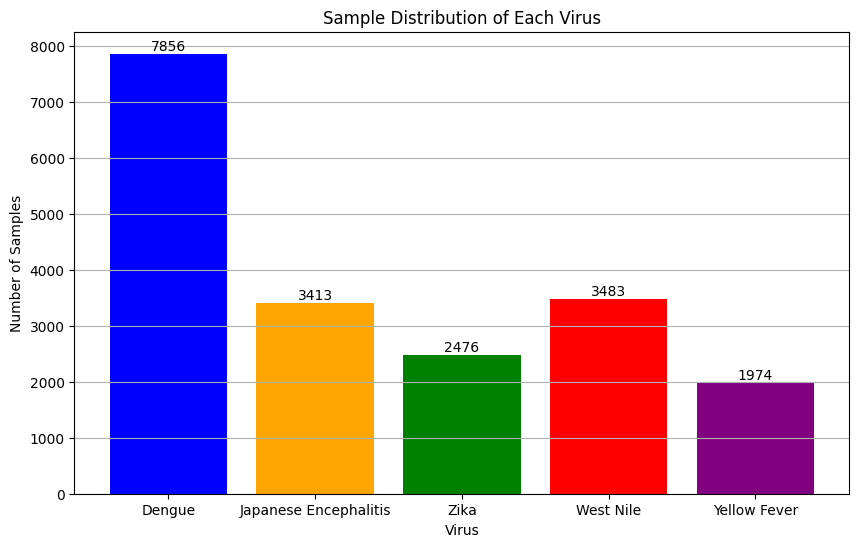

In [30]:
plot_sample_distribution(dengue_count, japanese_encephalitis_count, zika_count, west_nile_count, yellow_fever_count)

It is clear that the dataset is imbalanced. So after dividing it into training, validation, and test sets, I apply a combination of SMOTE and Random Undersampling to it.



## Sequences preprocessing

The function below implements preprocessing of a string into a numerical sequence (label encoding) using a dictionary where each symbol corresponds to a certain number. The dictionary is formed dynamically, here is an example of it: {'C': 1, 'A': 2, 'T': 3, 'G': 4}.

Decoding example using the dictionary above: "ATGGTCATGCCA" — [2,3,4,4,3,1,2,3,4,1,1,2]

In [31]:
def prepare_data(seqs):
    max_len = 0
    voc2ind = {voc:ind for ind,voc in enumerate(['<pad>', '<unk>'])}
    i = len(voc2ind)

    tokenized_seqs = []
    for seq in seqs:
        tokenized_seq = []
        for e in seq:
            seq = seq.upper()
            if not e in voc2ind:
                voc2ind[e] = i
                i += 1
            tokenized_seq.append(voc2ind[e])
        tokenized_seqs.append(tokenized_seq)

    return tokenized_seqs, voc2ind

DNA fragments that are originally less than 500 nucleotides long are padded to this length with "0" characters. For example, if the data set contains two samples "ATGGTCATGCCA" and "CATGGACT", then they are encoded as follows: [2,3,4,4,3,1,2,3,4,1,1,2] and [1,2,3,4,4,2,1,3,0,0,0,0], respectively. The second sequence is padded to match the length of the first — max length

In [32]:
def pad(tokenized_seqs, voc2ind):

    padded_seqs = []

    # find max sequence length
    max_len = 0
    for seq in tokenized_seqs:
        max_len = max(len(seq), max_len)

    # add padding so sequences are max_length
    for seq in tokenized_seqs:
        padded_seq = seq + [voc2ind['<pad>']] * (max_len - len(seq))
        padded_seqs.append(padded_seq)

    return np.array(padded_seqs, dtype=np.float32)

In the sell below I preprocess the sequences with functions defined above — encoding and padding.

Then we are getting a look at the example of an original sequence and its encoded form before and after padding. We can also see the formed dictionary.

In [33]:
token_seq, voc2ind = prepare_data(sequences)
padded_secs = pad(token_seq, voc2ind)
print("Example of an original sequence:\n", sequences[0])
print("\nThe sequence above after encoding:\n", token_seq[0], "\n\nUsed dictionary:\n", voc2ind, "\n\nThe sequence above after padding:\n", padded_secs[0])

Example of an original sequence:
 AAGCATGGATGGTACACAGACAATGGTTTTTTGACCTACCTCTACCATGGACATCAGGGGCTACAACAGAAACACCAACCTGGAATAAGAAAGAGCTTCTCGTGACATTCAAAAACGCACACGCAAAAAAACAAGAAGTAGTAGTCCTTGGATCGCAAGAGGGAGCAATGCACACAGCACTGACAGGAGCTACAGAGATCCAAACCTCAGGAGGCACAAGTATTTTTGCGGGGCACTTGAAATGCAGACTCAAGATGGACAAATTGGAACTCAAGGGGATGAGCTATGCAATGTGCTCGAATGCCTTTGTGTTGAAGAAAGAAGTCTCTGAAACACAACATGGGACAATACTCATTAAGGTCGAGTACAAAGGGGAAGACGCACCTTGCAAGATTCCTTTCTTTACGGAGGATGGACAAGGGAAAGCCCACAATGGCAGACTGATCACAGCTAACCCAGTGGTGACCAAGAAGGAGGAGCCTGTCAATATTGAGGCAGAA

The sequence above after encoding:
 [2, 2, 3, 4, 2, 5, 3, 3, 2, 5, 3, 3, 5, 2, 4, 2, 4, 2, 3, 2, 4, 2, 2, 5, 3, 3, 5, 5, 5, 5, 5, 5, 3, 2, 4, 4, 5, 2, 4, 4, 5, 4, 5, 2, 4, 4, 2, 5, 3, 3, 2, 4, 2, 5, 4, 2, 3, 3, 3, 3, 4, 5, 2, 4, 2, 2, 4, 2, 3, 2, 2, 2, 4, 2, 4, 4, 2, 2, 4, 4, 5, 3, 3, 2, 2, 5, 2, 2, 3, 2, 2, 2, 3, 2, 3, 4, 5, 5, 4, 5, 4, 3, 5, 3, 2, 4, 2, 5, 5, 4, 2, 2, 2, 2, 2, 4, 3, 4, 2, 4, 2, 4, 3, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3, 2, 2, 3, 5, 2, 3, 5, 2

## Forming a dataframe for CNNs to work with
In the sells below I'm forming and downloading a pandas dataframe of padded numerical sequences. 'Label' column determines one of 5 possible viruses for the sequence. This very dataframe is then used as initial data for CNNs

In [34]:
data_tokenized = pd.DataFrame(padded_secs)
data_tokenized['label'] = labels

In [35]:
data_tokenized

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,label
0,2.0,2.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,5.0,...,3.0,2.0,3.0,3.0,4.0,2.0,3.0,2.0,2.0,0
1,5.0,2.0,4.0,2.0,2.0,5.0,3.0,3.0,5.0,5.0,...,3.0,2.0,4.0,2.0,5.0,3.0,4.0,5.0,5.0,0
2,5.0,5.0,2.0,2.0,2.0,4.0,3.0,4.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3.0,2.0,2.0,2.0,4.0,3.0,4.0,3.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4.0,3.0,4.0,3.0,4.0,3.0,2.0,3.0,2.0,2.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19197,3.0,4.0,4.0,2.0,4.0,3.0,2.0,2.0,3.0,4.0,...,4.0,2.0,4.0,4.0,4.0,5.0,4.0,2.0,2.0,4
19198,3.0,5.0,5.0,2.0,4.0,2.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
19199,4.0,4.0,4.0,2.0,4.0,4.0,2.0,5.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
19200,3.0,3.0,2.0,2.0,5.0,5.0,4.0,2.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [36]:
data_tokenized.to_csv('/content/drive/My Drive/Classification of Viral DNA Data/data_tokenized_19202_500.csv', index=False)

In [37]:
df_verify = pd.read_csv('/content/drive/My Drive/Classification of Viral DNA Data/data_tokenized_19202_500.csv')
print(df_verify)

         0    1    2    3    4    5    6    7    8    9  ...  491  492  493  \
0      2.0  2.0  3.0  4.0  2.0  5.0  3.0  3.0  2.0  5.0  ...  3.0  2.0  3.0   
1      5.0  2.0  4.0  2.0  2.0  5.0  3.0  3.0  5.0  5.0  ...  3.0  2.0  4.0   
2      5.0  5.0  2.0  2.0  2.0  4.0  3.0  4.0  3.0  4.0  ...  0.0  0.0  0.0   
3      3.0  2.0  2.0  2.0  4.0  3.0  4.0  3.0  4.0  3.0  ...  0.0  0.0  0.0   
4      4.0  3.0  4.0  3.0  4.0  3.0  2.0  3.0  2.0  2.0  ...  3.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19197  3.0  4.0  4.0  2.0  4.0  3.0  2.0  2.0  3.0  4.0  ...  4.0  2.0  4.0   
19198  3.0  5.0  5.0  2.0  4.0  2.0  3.0  3.0  3.0  3.0  ...  0.0  0.0  0.0   
19199  4.0  4.0  4.0  2.0  4.0  4.0  2.0  5.0  4.0  3.0  ...  0.0  0.0  0.0   
19200  3.0  3.0  2.0  2.0  5.0  5.0  4.0  2.0  4.0  5.0  ...  0.0  0.0  0.0   
19201  4.0  4.0  4.0  2.0  4.0  4.0  2.0  5.0  4.0  3.0  ...  0.0  0.0  0.0   

       494  495  496  497  498  499  label  
0     